In [14]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import matplotlib.pyplot as plt

In [15]:
csv_file_path = '/home/lucas/UFOP/ple_2020/analise_midias_sociais/final-work/data/all_pp_posts_bolsonaro_replaced_to_empty_removing_other_words.csv'
df_candidate = pd.read_csv(csv_file_path,encoding = 'utf-8')

In [16]:
# convertendo o tipo data que esta como string em objeto no formato data
df_candidate["created_time"] = pd.to_datetime(df_candidate['created_time'])

In [17]:
df_candidate.head(15)

,created_time,id,message_max_processed,m_m_p_replaced_to_empty,shares,status_type,full_picture,reactions_like,reactions_haha,reactions_wow,reactions_sad,reactions_angry,reactions_love,has_textual_message
0,2020-03-22 18:47:55+00:00,211857482296579_1826486634166981,agora videoconferencia presidente jair bolsona...,agora videoconferencia presidente presidente...,23151,added_photos,https://scontent.xx.fbcdn.net/v/t1.0-0/p180x54...,129465,147,318,21,112,10345,True
1,2020-03-22 16:30:39+00:00,211857482296579_1826339070848404,inscricoes selecao profissionais atuacao progr...,inscricoes selecao profissionais atuacao progr...,5703,mobile_status_update,None,52238,128,61,5,43,2514,True
2,2020-03-22 13:37:26+00:00,211857482296579_1826130007535977,ministerio saude ministro mandetta reuniao vir...,ministerio saude ministro mandetta reuniao vir...,11818,added_photos,https://scontent.xx.fbcdn.net/v/t1.0-0/p180x54...,97986,73,141,16,65,6292,True
3,2020-03-22 11:07:01+00:00,211857482296579_1825937284221916,governo federal distribui milhoes testes rapid...,governo federal distribui milhoes testes rapid...,39284,mobile_status_update,None,165539,88,393,20,68,16747,True
4,2020-03-22 02:06:48+00:00,211857482296579_1825422034273441,chama precaucao medicamento barato caso venha ...,chama precaucao medicamento barato caso venha ...,27236,added_photos,https://scontent.xx.fbcdn.net/v/t1.0-9/9052732...,162513,968,318,88,509,20723,True
5,2020-03-21 22:22:48+00:00,211857482296579_1825061764309468,reconheco seriedade momento temor muitos brasi...,reconheco seriedade momento temor muitos brasi...,40794,added_photos,https://scontent.xx.fbcdn.net/v/t1.0-9/9065012...,305358,918,478,266,1267,48834,True
6,2020-03-21 18:36:01+00:00,211857482296579_1824728371009474,hospital albert einstein possivel cura pacient...,hospital albert einstein possivel cura pacient...,201803,added_video,https://scontent.xx.fbcdn.net/v/t15.5256-10/75...,215237,480,815,60,431,34278,True
7,2020-03-21 11:33:30+00:00,211857482296579_1824261207722857,dois dedos prosa ratinho assista,dois dedos prosa ratinho assista,33971,added_video,https://scontent.xx.fbcdn.net/v/t15.5256-10/83...,106117,336,317,113,624,15368,True
8,2020-03-21 02:37:00+00:00,211857482296579_1823872341095077,assinei medida provisoria deixando claro ser c...,assinei medida provisoria deixando claro ser c...,9174,added_photos,https://scontent.xx.fbcdn.net/v/t1.0-9/s720x72...,112873,181,200,106,1121,7582,True
9,2020-03-21 00:16:41+00:00,211857482296579_1823743497774628,via eduardo bolsonaro,via eduardo,8150,added_photos,https://scontent.xx.fbcdn.net/v/t1.0-0/p600x60...,79762,435,111,13,160,6480,True


In [18]:
n_total_posts = len(df_candidate)
print('número total de posts: {0}'.format(str(n_total_posts)))

número total de posts: 3646


In [19]:
n_posts_with_textual_messages = df_candidate[df_candidate.has_textual_message == True].shape[0]
n_posts_without_textual_messages = df_candidate[df_candidate.has_textual_message == False].shape[0]

print('número de posts com mensagens textuais: {0}'.format(str(n_posts_with_textual_messages)))
print('número de posts sem mensagens textuais: {0}'.format(str(n_posts_without_textual_messages)))

número de posts com mensagens textuais: 3394
número de posts sem mensagens textuais: 252


In [22]:
#============================================================================================
# realizando o tf idf no df['pre_processed_message'] do corpus inteiro
#============================================================================================

# tf idf é uma medida estatística que tem o intuito de indicar a importância de uma palavra 
# de um documento em relação a uma coleção de documentos ou em um corpus linguístico.

def sort_columns(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)


def extract_top_n_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    return results

cv = CountVectorizer()

word_count_vector=cv.fit_transform(df_candidate['m_m_p_replaced_to_empty'])

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

# you only needs to do this once, this is a mapping of index to 
feature_names=cv.get_feature_names()

# get the document that we want to extract keywords from
corpus=' '.join(df_candidate['m_m_p_replaced_to_empty'])

#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([corpus]))

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_columns(tf_idf_vector.tocoo())

#extract only the top n; n here is 10
keywords=extract_top_n_from_vector(feature_names,sorted_items,10)

print("\n===Keywords===")
for key in keywords:
    print(key,keywords[key])


===Keywords===
brasil 0.282
pt 0.151
todos 0.146
governo 0.141
ministerio 0.122
obrigado 0.119
hoje 0.118
presidente 0.113
federal 0.102
eduardo 0.102


In [23]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

brasil : 876
pt : 349
todos : 342
governo : 310
obrigado : 260
hoje : 256
ministerio : 244
presidente : 232
eduardo : 208
dia : 200


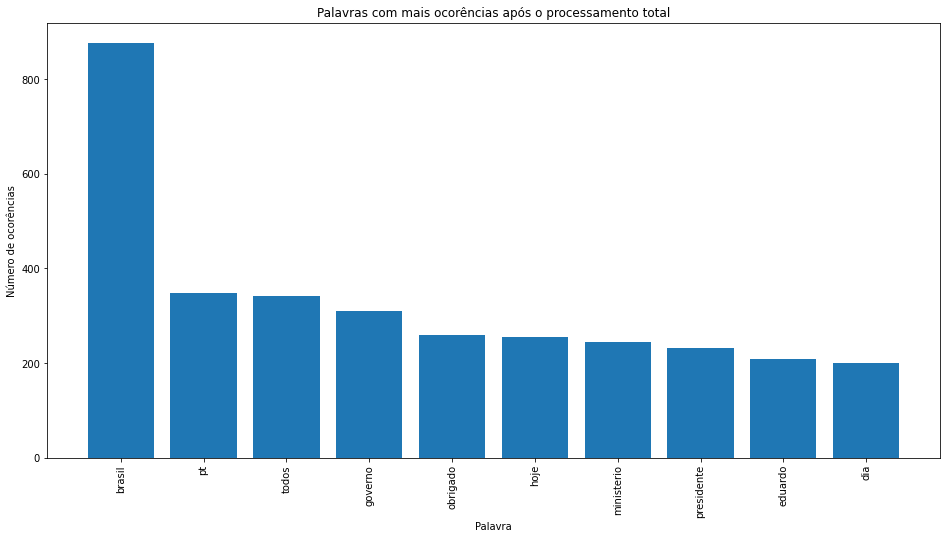

In [24]:
#=======================================================================
# visualização das top palavras
#=======================================================================

count_vectorizer = CountVectorizer()
words, word_values = get_top_n_words(n_top_words=10,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df_candidate['m_m_p_replaced_to_empty'])

for index in range(len(word_values)):
    print('{0} : {1}'.format(str(words[index]),str(word_values[index])))
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Palavras com mais ocorências após o processamento total');
ax.set_xlabel('Palavra');
ax.set_ylabel('Número de ocorências');
plt.show()
